In [1]:
rootf = './'

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
#---------------------------------
import sys
sys.path.append('./functions') 
from save_load import *
from functions_NO_MEA import*

Populating the interactive namespace from numpy and matplotlib


# Load data

In [3]:
from scipy.io import loadmat
import csv
Folder = rootf + 'data/TYPING_Baden/'
#-----------------------
# Baden data
baden = loadmat(Folder + 'baden_data.mat')
# #------------------------
chirp_stim = baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0])
chirp_stim_time = baden['chirp_stim_time'][0,:] + 2   # 2 seconds later than my stim
baden_time_original = baden['chirp_time'][0,:]   # 2 seconds later than my stim
group_idx = baden['group_idx'] 
psth_euler = baden['chirp_avg']
#-------------------
euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1
#-------------------        

### Stims

(-1, 2)

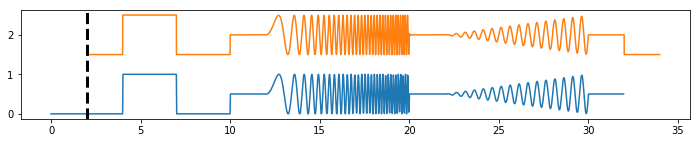

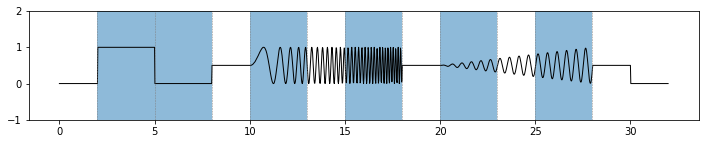

In [4]:
# Get Euler stim profile
def get_euler():
    vec_path = rootf + 'data/'
    vec_path = vec_path + r"chirp.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150:1750,1]/max(euler_vec[150:1750,1])) #return in 100ms steps

def get_euler2():
    vec_path = rootf + 'data/'
    vec_path = vec_path + r"chirp.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150+100:1750+100,1]/max(euler_vec[150+100:1750+100,1])) #return in 100ms steps

euler_vec= get_euler()

figure(figsize=(12,2))
time_stim = np.linspace(0,32,50*32+1)[:-1]
time = np.linspace(0,32,321)[:-1]
plot(time_stim,euler_vec)
euler_vec.shape
euler_vec[::5].shape,time.shape
# ylim([0,1])
plot(chirp_stim_time ,chirp_stim+1.5)
chirp_stim_time.shape, chirp_stim.shape

axvline(2,linestyle='--',color='k',lw=3)      # 2 s decalage

# comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)
#--------------------------------
# New Euler stim as Calcium traces
figure(figsize=(12,2))
euler_vec2 = get_euler2() 
plot(time_stim,euler_vec2,lw=1,color='k')

for l in [2,5,8,10,13,15,18,20,23,25,28]:
    axvline(l,linestyle='--',color='gray',lw=0.5)
Vregions = [[2,5],[5,8],[10,13],[15,18],[20,23],[25,28]]
for v in Vregions:
    axvspan(v[0], v[1], alpha=0.5)
ylim(-1,2)

### Euler calcium data

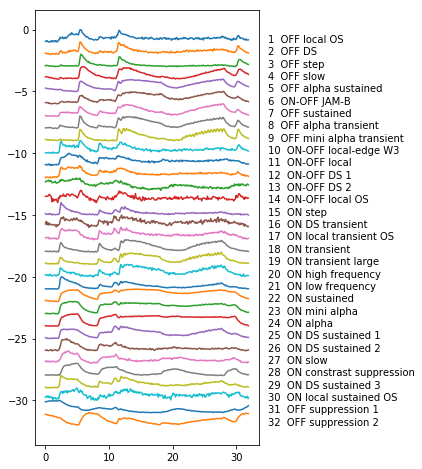

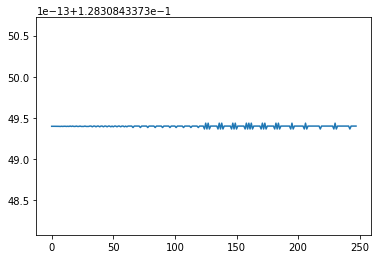

In [5]:
SHIFT_BADEN = False # if False we shift MEA data to fit Calcium data
# Generate Baden type traces
baden_time = baden_time_original
if SHIFT_BADEN:
    baden_time = baden_time_original+2
    baden_first = baden_time[-15:]-32
    baden_time=np.append(baden_first,baden_time[:-15])

Baden_types = []
figure(figsize=(4,8))
for i in np.arange(32)+1:
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)
    trace = trace-min(trace)
    trace = trace/max(trace)
    if SHIFT_BADEN:
        trace = np.append(trace[-15:],trace[:-15])                # I stitch las 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plot(baden_time,trace-i)
    text(35,-i,str(i)+'  '+euler_labels[i-1][0])

figure()
plot(diff(baden_time))

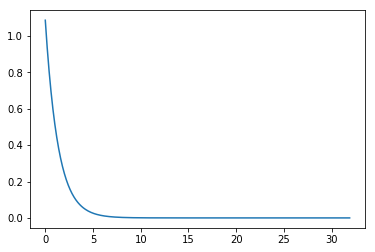

In [6]:
shift=0
# functions for calcium traces
def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train)+shift:len(spike_train)*2+shift];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace
    

calcium_filter = calcium_exp(time);
plot(time,calcium_filter)

calcium_filter = calcium_exp(time);

def toCalciumLinear3(time_sequence, spike_trains):
    calcium_traces = []
    spike_trains = np.array(spike_trains)
    
    for spike_train in spike_trains:
        stitch3 = np.append(spike_train,[spike_train,spike_train])
        # normalizations with respect to control
#         stitch3=stitch3-np.amin(spike_trains[0])
#         stitch3=stitch3/np.sum(spike_trains[0])  #################
#         stitch3=stitch3/np.amax(spike_trains)

        calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train)+shift:len(spike_train)*2+shift];
        
        calcium_traces.append(calcium_trace)
        
    calciumm_traces = np.array(calcium_traces)          
    
    # all normalization with respect to control
    calcium_traces = calcium_traces-np.amin(calcium_traces[0])
    calcium_traces=calcium_traces/np.amax(calcium_traces[0])
        
#         print(np.max(calcium_trace))
        
    return calcium_traces

### Experiment to calcium data

In [7]:
time = np.linspace(0,32,321)[:-1]

Fsave = rootf + '/data/MEA_Data/pckls_ID/'

LABELS = {}
PSTH_Z = {}
G_LABELS = {}

for G in np.arange(32):
    fsave = Fsave + 'clustermodel'+str(G)
    try:
        model, psth_z = load_obj(fsave)
    

        labels = model.labels_
        G_LABELS[G] = np.sort(np.unique(labels))

        # Transform to BADEN times (stitch first 2 seconds in the end)
        if SHIFT_BADEN==False:
            i=0
            for p in psth_z:
                psth_z[i]=np.append(psth_z[i][20:],psth_z[i][0:20])
                i+=1

        LABELS[G] =labels
        PSTH_Z[G] = np.copy(psth_z)
    
    except:
        print('no data group ',G)
        
# Adding subgroup to Group 8    
PSTH_Z[8] = np.append(PSTH_Z[8],PSTH_Z[31][LABELS[31]==3,:],axis=0) # we reasign subcluster 3 preclustered as group 31
LABELS[8] = np.append(LABELS[8],LABELS[31][LABELS[31]==3]-2)
G_LABELS[8] =np.array([0,1])

print('Groups 18 and 26 have 1 cell each')

no data group  18
no data group  26
no data group  27
no data group  29
Groups 18 and 26 have 1 cell each


/Users/matias/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator AgglomerativeClustering from version 1.3.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


/Users/matias/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


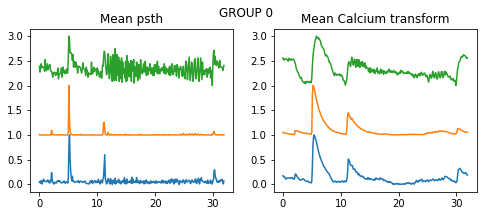

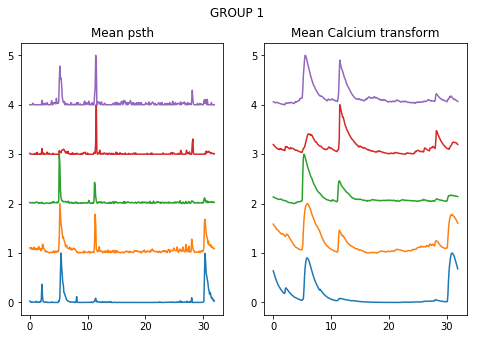

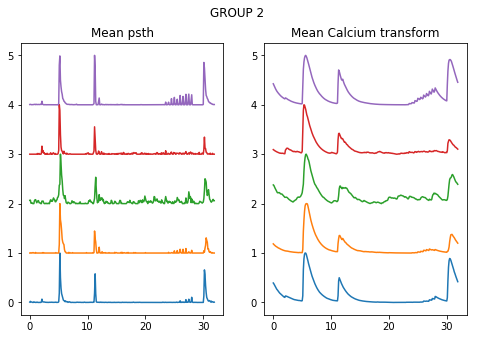

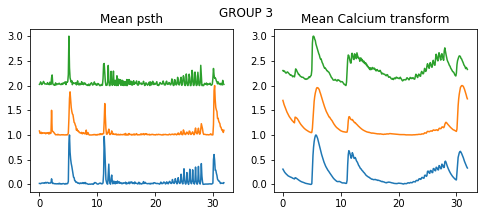

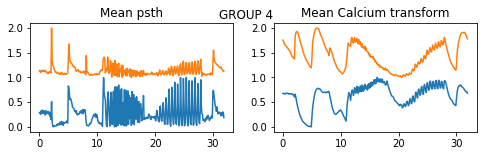

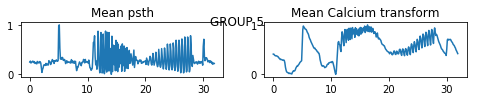

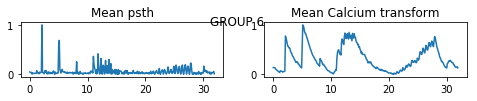

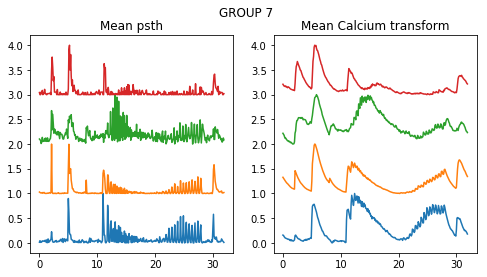

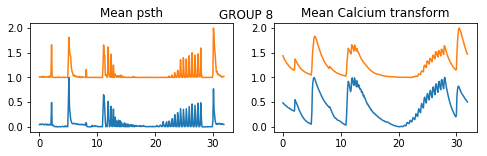

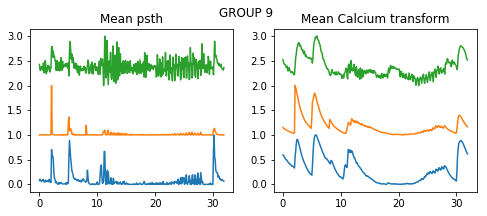

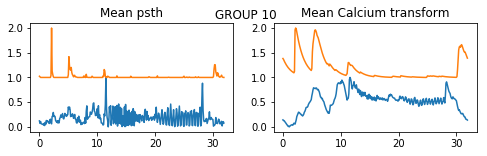

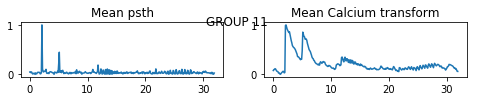

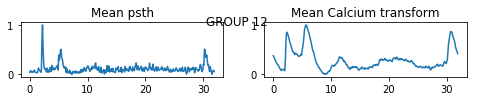

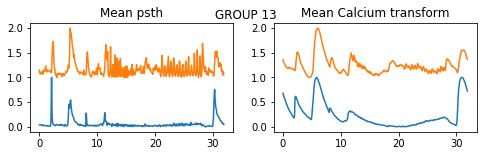

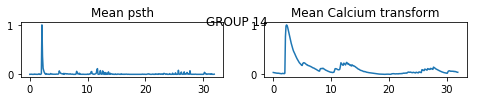

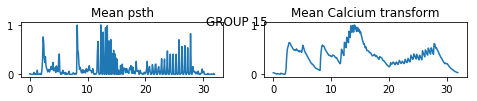

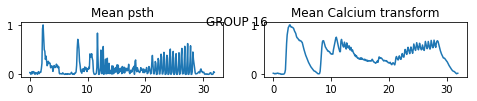

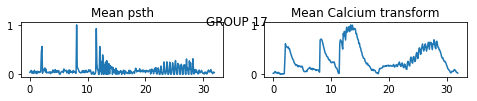

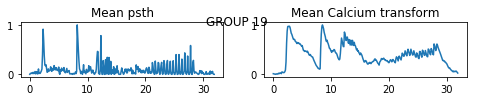

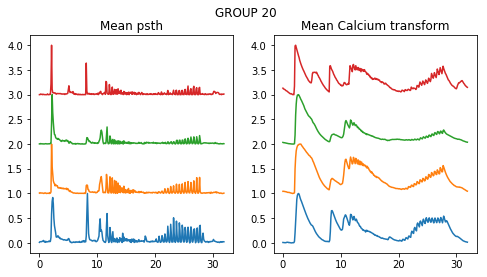

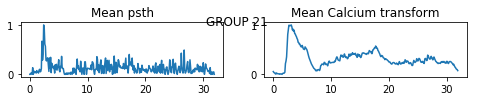

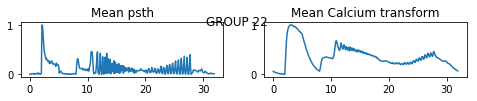

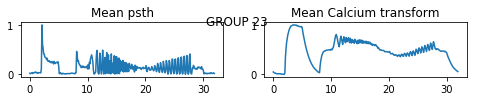

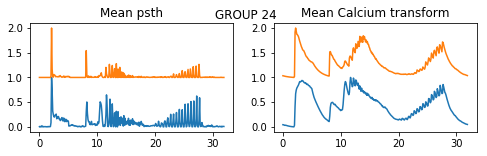

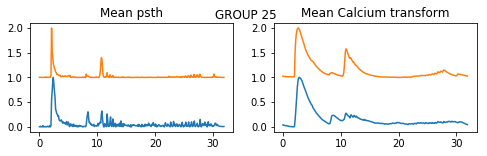

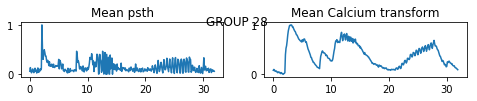

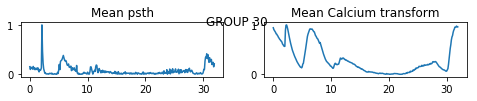

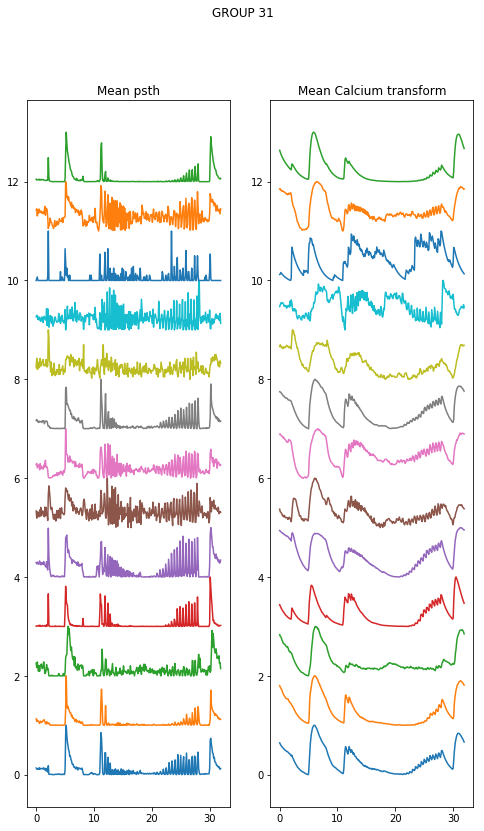

In [8]:
# Generate experiment type traces
G_TYPES={}
G_TYPES_CA={}

for G in list(G_LABELS.keys()):
        
    Exp_types = []
    fig = figure(figsize=(8,len(G_LABELS[G])*1))
    fig.suptitle('GROUP '+str(G))
    fig.add_subplot(1,2,1)
    for i in G_LABELS[G]:
        trace = np.mean(PSTH_Z[G][(LABELS[G]==i),:],0)
        trace = trace-min(trace)
        trace = trace/max(trace)
        Exp_types.append(trace)
        plot(time,trace+i)
        title('Mean psth')
        
    G_TYPES[G] = Exp_types
    
    # Experiment to calcium
    Exp_types_Ca = {}
    fig.add_subplot(1,2,2)
    for i in G_LABELS[G]:
        trace = toCalciumLinear(time,G_TYPES[G][i])
        Exp_types_Ca[i] = trace
        plot(time,trace+i)
        title('Mean Calcium transform')
        
    G_TYPES_CA[G]=Exp_types_Ca

# LOAD DATA

In [9]:
Fsave = rootf + 'data/MEA_Data/pckls_ID/'

fsave = Fsave +  'group32_celldataID'
cell_data = load_obj(fsave)

SELECTED_CELLS = {}

for G in list(G_LABELS.keys()):
    fsave = Fsave + 'selected_cells' + str(G)
    selected_cells = load_obj(fsave)
    
    SELECTED_CELLS[G] = selected_cells
    
# add for group 8
N=len(SELECTED_CELLS[8])
for i in np.arange(sum(LABELS[31]==3)):
    SELECTED_CELLS[8].update({N+i: SELECTED_CELLS[31][np.where(LABELS[31]==3)[0][i]]})

# New Cluster Labels

In [10]:
# My list of group cells

GROUPS = G_LABELS

CLUSTERS = [
    [1],              #0
    [0,1,2],
    [0,1,3,4],
    [0,1,2],
    [0,1],           
    [0],              #5
    [0],
    [0,1,2],
    [0,1],
    [0,1,2],
    [0,1],            #10
    [0],
    [0],
    [0,1],
    [0],
    [0],              #15
    [0] ,
    [0] ,
    []   ,               #18 one cell
    [0],
    [0,1,2,3],               #20
    [0] ,
    [0],
    [0],
    [0,1],
    [0,1],            #25
    [],                   #26 one cell
    [] ,                  #27  NO CELLS
    [0],
    [],                   #29  NO CELLS
    [0],                 #30
    [0,7,5,6,9,11, 1,12 ,2, 4,8,10]  # 2,4,8,10 will be discarded
]

# bad cells that were not recorded with stability across the 3 conditions
BAD_CELLS = [ 
    [65,53] ,               #0
    [2,80,6  ,18,21, 61,72,78,82,6 ],
    [10,69,     9,   48,54,91,93],
    [3,5,50,59,80,87],
    [40,58,69,   ]  ,       
    [52,     19,46,100],    #5
    [],
    [62,96],
    [92,81,52,22,4, 49, 140, ],
    [72,68],
    [],                    #10
    [],
    [31],
    [32,88,93],
    [6,35],
    [],                 #15          
    [],
    [89],
    [],                       #18 one cell
    [],                 
    [36,29,52,144],                 # 20
    [5],
    [18,20],              
    [],
    [100],
    [],               #25
    [],                    #26 one cell
    [],                   #27  NO CELLS
    [48],
    [],                       #29  NO CELLS
    [105,19] ,           #30
    [66]                        
]


SubGroups32 = [[0,7],[5,6,9,11],[1,12],[2,4,8,10]]    #  last subgroup is discarded


NEW_LABELS = {}
for G in G_LABELS.keys():
    Groups = []
    for gg in GROUPS[G]:   
        Groups.append([gg])
        
    for G in list(G_LABELS.keys()):

        new_labels = np.zeros(len(LABELS[G]))

        for g,groups in enumerate(Groups):
            for n in groups:
                clustersin = [np.where((LABELS[G]==n))[0]][0]
                for j in clustersin:
                    new_labels[j]=g

        NEW_LABELS[G] = new_labels
    

/Users/matias/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


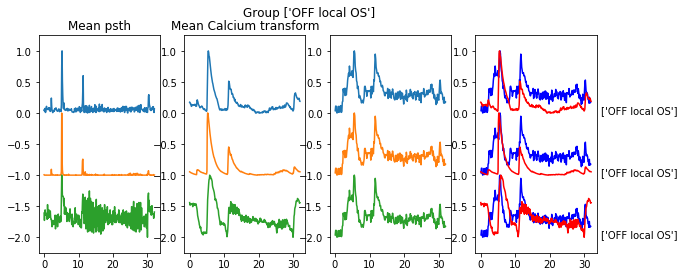

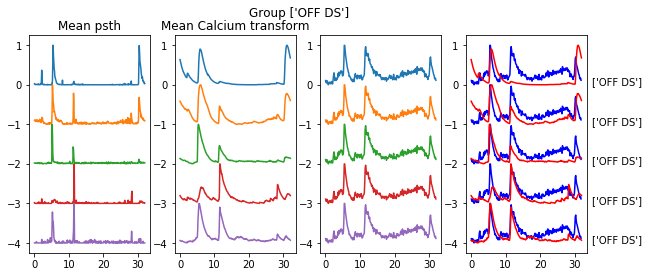

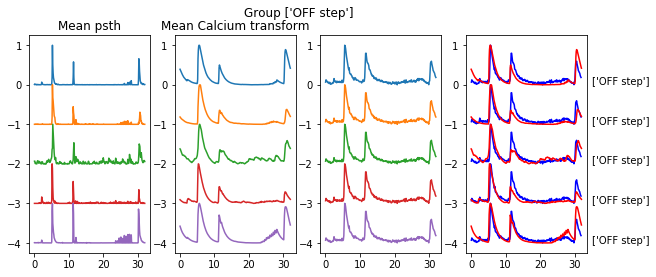

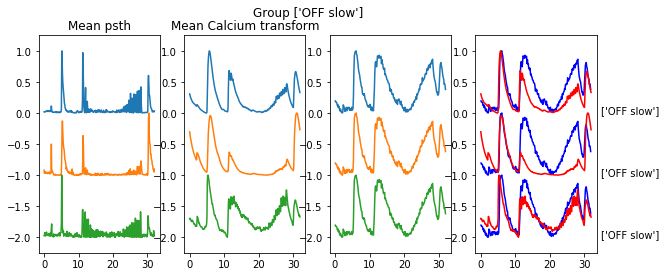

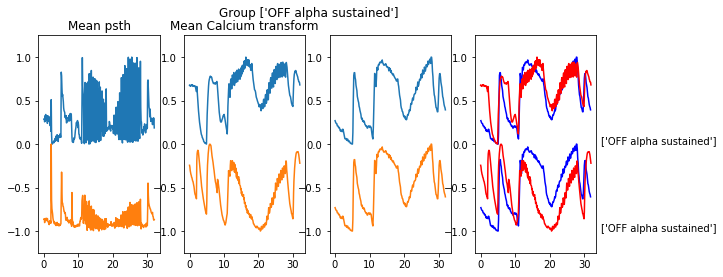

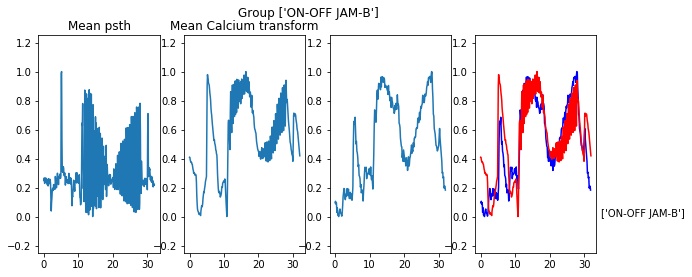

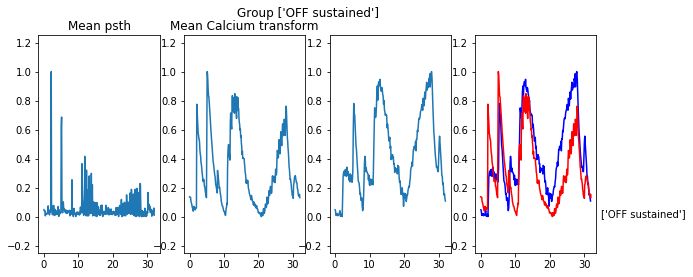

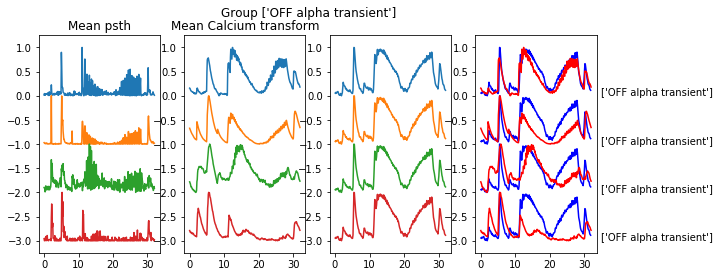

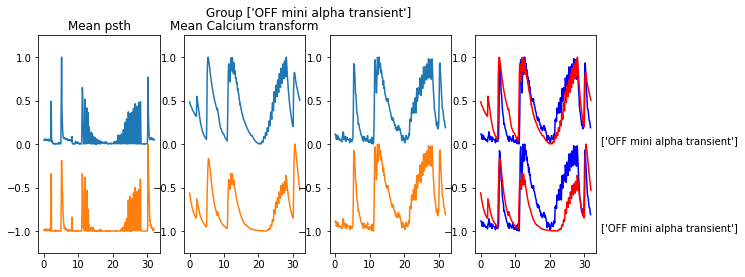

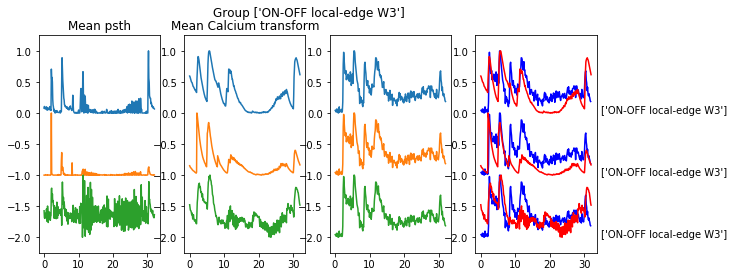

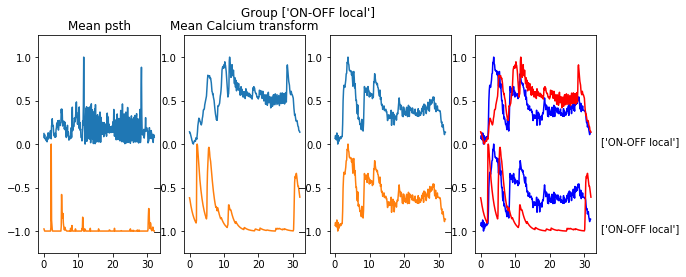

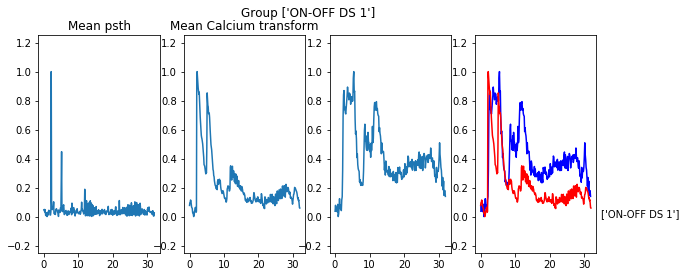

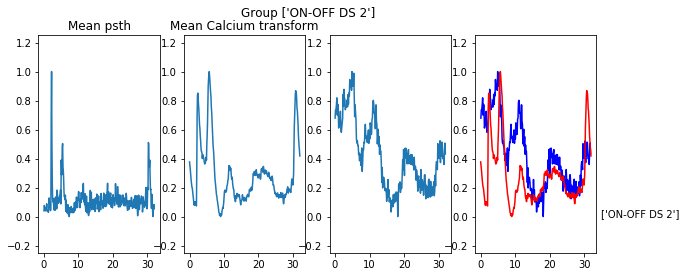

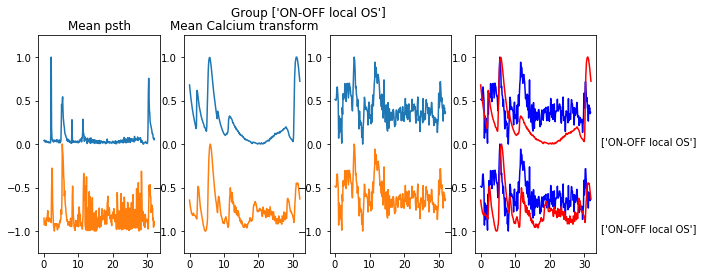

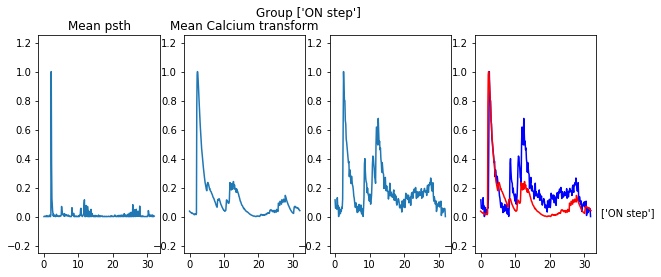

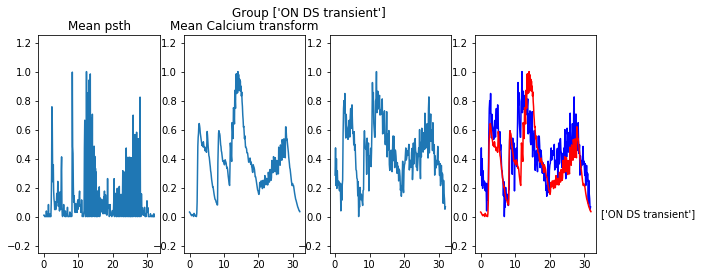

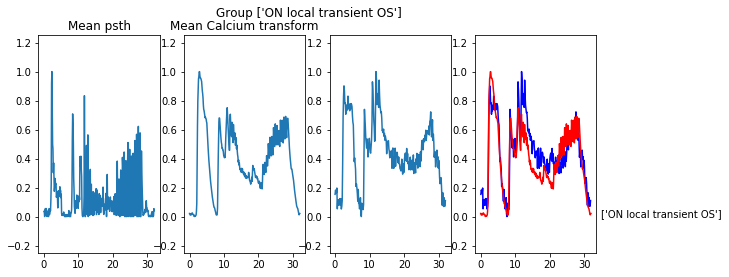

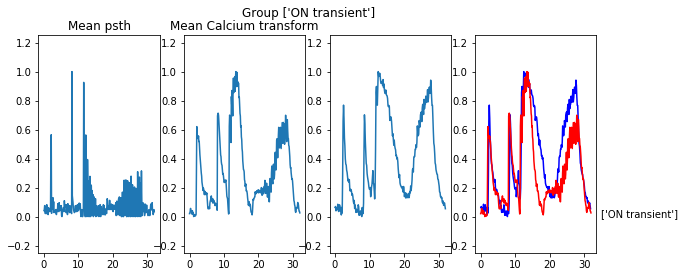

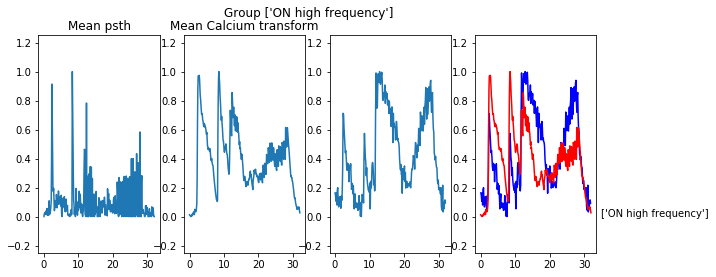

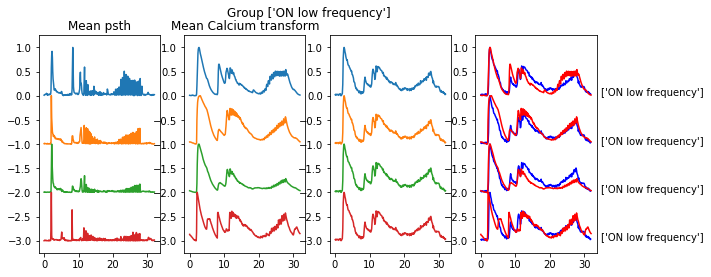

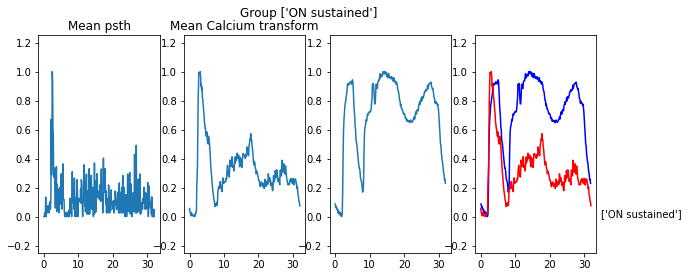

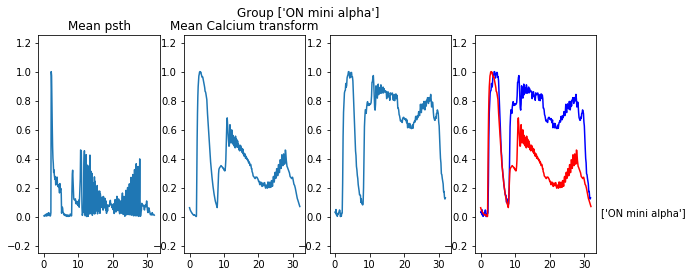

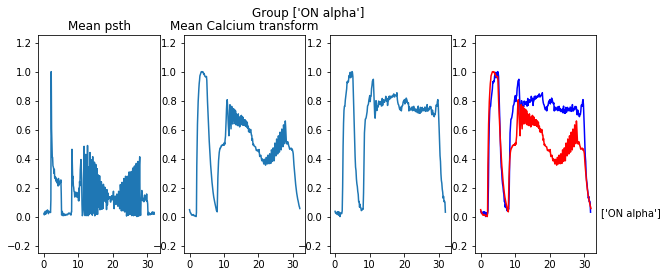

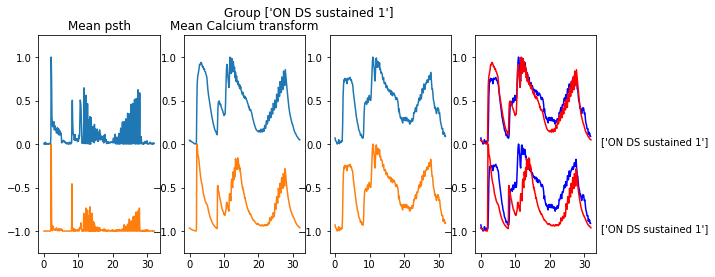

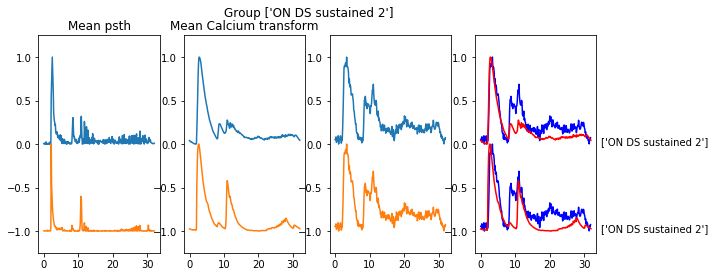

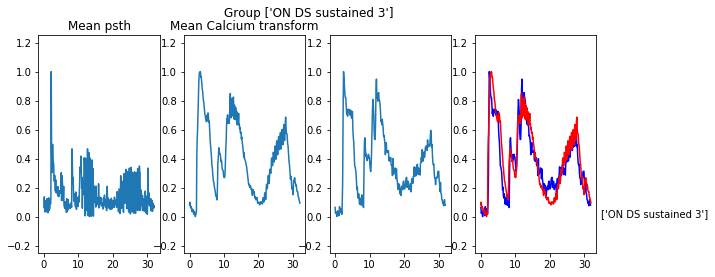

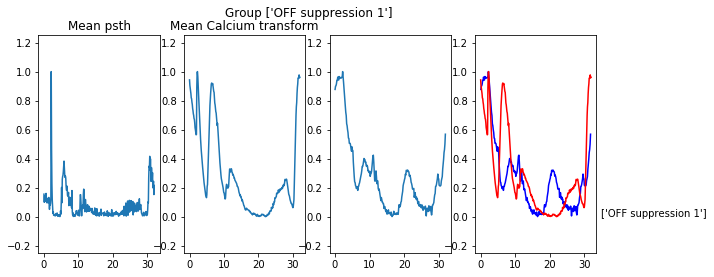

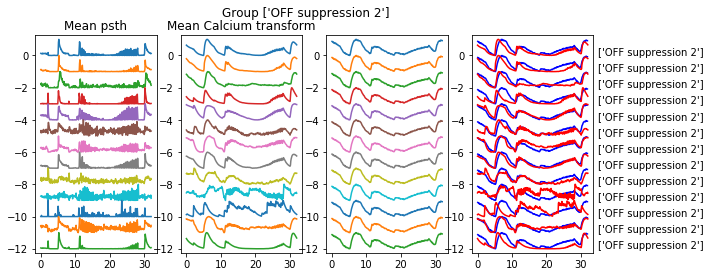

In [11]:
time = np.linspace(0,32,320)

# EXP_SORTED_TYPES = {}

for G in G_LABELS.keys():

    N_groups = len(GROUPS[G])

    # Generate new experiment type traces
    Exp_sorted_types = []
    fig = figure(figsize=(10,4))
    fig.suptitle('Group '+str(euler_labels[G]))
    fig.add_subplot(1,4,1)
    
    for i in np.arange(32)[0:N_groups]:
        trace = np.mean(PSTH_Z[G][(NEW_LABELS[G]==i),:],0)
        trace = trace-min(trace)
        trace = trace/max(trace)
        Exp_sorted_types.append(trace)
        plot(time,trace-i)
        title('Mean psth')
        ylim([-N_groups+0.75,1.25])

    # Experiment to calcium
    Exp_sorted_types_Ca = {}
    fig.add_subplot(1,4,2)
    for i in np.arange(32)[0:N_groups]:
        trace = toCalciumLinear(time,Exp_sorted_types[i])
        Exp_sorted_types_Ca[i] = trace
        plot(time,trace-i)
        title('Mean Calcium transform')
        ylim([-N_groups+0.75,1.25])
    fig.add_subplot(1,4,3)

    for i in list(euler_labels.keys())[0:N_groups]:
            plot(baden_time,Baden_types[G]-i)
            ylim([-N_groups+0.75,1.25])

    fig.add_subplot(1,4,4)
    for i in np.arange(32)[0:N_groups]:
            plot(baden_time,Baden_types[G]-i,'b')
            plot(time,Exp_sorted_types_Ca[i]-i,'r')
            text(35,-i,euler_labels[G])
            ylim([-N_groups+0.75,1.25])

# ANALYSIS

# Calculate with proper normalization per cell

In [12]:
shift_sp=0
if SHIFT_BADEN==False:
    shift_sp = 50   #50 for baden lab specs, matching MEA data to Calcium data

time = np.linspace(0,32,800)
Timespans = []
Vregions = [[2,5],[5,8],[10,13],[15,18],[20,23],[25,28],[2,30]]
for v in Vregions:
    span = np.where((time>v[0]) & (time <=v[1]))[0]
    Timespans.append(span)

In [13]:
# for some reason python np.corcoef gave me nan values when variance was 0
def pearson(x,y):
  n=len(x)
  vals=range(n)

  sumx=sum([float(x[i]) for i in vals])
  sumy=sum([float(y[i]) for i in vals])

  sumxSq=sum([x[i]**2.0 for i in vals])
  sumySq=sum([y[i]**2.0 for i in vals])

  pSum=sum([x[i]*y[i] for i in vals])
  # Calculating Pearson correlation
  num=pSum-(sumx*sumy/n)
  den=((sumxSq-pow(sumx,2)/n)*(sumySq-pow(sumy,2)/n))**.5
  if den==0: return 0
  r=num/den
  return r

In [14]:
# Define variables

def initialize():

    time = np.linspace(0,32,800)
    calcium_filter = calcium_exp(time) # new filter timescale

    # PSTH_means
    Mc1 = {}
    Mno = {}
    Mwo = {}
    # PSTH_stdevs
    Sc1 = {}
    Sno = {}
    Swo = {}
    #psths
    Psthsc1 = {}
    Psthsno = {}
    Psthswo = {}
    #Ca traces
    Cac1 = {}
    Cano = {}
    Cawo = {}
    # Ca_means
    CaMc1 = {}
    CaMno = {}
    CaMwo = {}
    # Ca_stdevs
    CaSc1 = {}
    CaSno = {}
    CaSwo = {}
    #Totals

    Catotc1= {}
    Catotno= {}
    Catotwo= {}
    Scatotc1= {}
    Scatotno= {}
    Scatotwo= {}

    Totc1 = {}
    Totno = {}
    Totwo = {} 
    Stotc1 = {}
    Stotno = {}
    Stotwo = {}

    Ncells = {}

    # DELTAS

    DD = {}
    DDP = {}
    CC = {}
    CCP = {}

    for G in G_LABELS.keys():

        # PSTH_means
        Mc1[G] = {}
        Mno[G] = {}
        Mwo[G] = {}
        # PSTH_stdevs
        Sc1[G] = {}
        Sno[G] = {}
        Swo[G] = {}
        #psths
        Psthsc1[G] = {}
        Psthsno[G] = {}
        Psthswo[G] = {}
        #Ca traces
        Cac1[G] = {}
        Cano[G] = {}
        Cawo[G] = {}
        # Ca_means
        CaMc1[G] = {}
        CaMno[G] = {}
        CaMwo[G] = {}
        # Ca_stdevs
        CaSc1[G] = {}
        CaSno[G] = {}
        CaSwo[G] = {}
        #Totals

        Catotc1[G]= []
        Catotno[G]= []
        Catotwo[G]= []
        Scatotc1[G]= []
        Scatotno[G]= []
        Scatotwo[G]= []

        Totc1[G] = []
        Totno[G] = []
        Totwo[G] = [] 
        Stotc1[G] = []
        Stotno[G] = []
        Stotwo[G] = []

        Ncells[G] = {}

        # DELTAS

        DD[G] = {}
        DDP[G] = {}
        CC[G] = {}
        CCP[G] = {}

        for g in CLUSTERS[G]:
            Mc1[G][g]=[]
            Mno[G][g]=[]
            Mwo[G][g]=[]
            Sc1[G][g]=[]
            Sno[G][g]=[]
            Swo[G][g]=[]
            Psthsc1[G][g]=[]
            Psthsno[G][g]=[]
            Psthswo[G][g]=[]
            Cac1[G][g] = []
            Cano[G][g] = []
            Cawo[G][g] = []

            DD[G][g]= []
            DDP[G][g]= []
            CC[G][g] = []
            CCP[G][g] = []

            Ncells[G][g] = 0
            
    return [time,calcium_filter,Mc1,Mno,Mwo,Sc1,Sno,Swo,Psthsc1,Psthsno,Psthswo,Cac1,Cano,Cawo,CaMc1,CaMno,CaMwo,CaSc1,CaSno,CaSwo,Catotc1,
           Catotno,Catotwo,Scatotc1,Scatotno,Scatotwo,Totc1,Totno,Totwo,Stotc1,Stotno,Stotwo,Ncells,DD,DDP,CC,CCP]

In [15]:
[time,calcium_filter,Mc1,Mno,Mwo,Sc1,Sno,Swo,Psthsc1,Psthsno,Psthswo,Cac1,Cano,Cawo,CaMc1,CaMno,CaMwo,CaSc1,CaSno,CaSwo,Catotc1,
Catotno,Catotwo,Scatotc1,Scatotno,Scatotwo,Totc1,Totno,Totwo,Stotc1,Stotno,Stotwo,Ncells,DD,DDP,CC,CCP]= initialize()
#
Ntot={}
Nc1={}
Nno={}
Nwo={}
for G in list(G_LABELS.keys())[:]:
    print('')
    print('GROUP ',G)
    
    Ntot[G]=0
    cc=0
    for icluster2 in CLUSTERS[G]:
        # Group 32 treatment
        icluster=icluster2
        if G==31:
            if icluster2 in SubGroups32[0]: 
                icluster=0
            else:
                if icluster2 in SubGroups32[1]: 
                    icluster=1
                else:
                    if icluster2 in SubGroups32[2]: 
                        icluster=5
                    else:
                        icluster=6   
        ########
        
        idx_cluster = np.where(NEW_LABELS[G]==icluster2)[0]
        print(icluster,idx_cluster)

        for index in sorted(idx_cluster):

            cell_nb = index  

            exp,cell_idx, cell_name = SELECTED_CELLS[G][cell_nb]

            # Bad clusters out (exceptions for cell number that was repeated across experiments)
            if cell_idx in BAD_CELLS[G] and not(cell_idx==69 and exp==7 and G==2) and not(cell_idx==66 and  G==31 and (exp==4 or exp==5 or exp==7)):  
#                 print('bad cell',icluster, cell_idx)
                continue
            Ncells[G][icluster]=Ncells[G][icluster]+1
            #print(icluster, exp, cell_name)
            p1 = np.append(cell_data[exp][cell_idx]['psth_c1'][shift_sp:],cell_data[exp][cell_idx]['psth_c1'][0:shift_sp])
            p2 = np.append(cell_data[exp][cell_idx]['psth_no'][shift_sp:],cell_data[exp][cell_idx]['psth_no'][0:shift_sp])
            p3 = np.append(cell_data[exp][cell_idx]['psth_wo'][shift_sp:],cell_data[exp][cell_idx]['psth_wo'][0:shift_sp])

            Psthsc1[G][icluster].append(p1)
            Psthsno[G][icluster].append(p2)
            Psthswo[G][icluster].append(p3)

            # the calcium transformation has to be normalized to the maximum of the original one c1 in order
            # to compare properly      
            traces = [p1,p2,p3] 
            traces = toCalciumLinear3(time,traces)
            Cac1[G][icluster].append(traces[0])
            Cano[G][icluster].append(traces[1])
            Cawo[G][icluster].append(traces[2])
            
            Alldeltas=[]
            AlldeltasP = []
            AllCor=[]
            AllCorP=[]

            for t in Timespans:

                Area = 75#np.sum(traces[0][t])  #75

                Delta = np.sum(traces[1][t] - traces[0][t])
                DeltaNO = (Delta/Area)
                Delta = np.sum(traces[2][t] - traces[0][t])
                DeltaWO = (Delta/Area)

                CNO = pearson(traces[1][t], traces[0][t])#[0,1]
                CWO = pearson(traces[2][t], traces[0][t])#[0,1]

                AllCor.append([CNO,CWO])

                Alldeltas.append([DeltaNO,DeltaWO])  # calculate all 6 Regions
                #--------
                Area = 3  # Delta t to have it in firing rate

                Delta = np.sum(p2[t] - p1[t])
                DeltaNO = (Delta/Area)
                Delta = np.sum(p3[t] - p1[t])
                DeltaWO = (Delta/Area)

                CNO = pearson(p2[t], p1[t])#[0,1]
                CWO = pearson(p3[t], p1[t])#[0,1]

                if isnan(CNO) or isnan(CWO): 
                    plot(p1[t])
                    print(exp,cell_idx,cell_name, t[0])

                AllCorP.append([CNO,CWO])

                AlldeltasP.append([DeltaNO,DeltaWO])  # calculate all 6 Regions

            Alldeltas[-1] =list(np.array(Alldeltas[-1])*(3/28) )  # 28 sec instead of 3
            AlldeltasP[-1]=list(np.array(AlldeltasP[-1])*(3/28) )  # 28 sec instead of 3

            DD[G][icluster].append(Alldeltas) # Append all regions for a cell in a cluster
            DDP[G][icluster].append(AlldeltasP) 
            CC[G][icluster].append(AllCor) # Append all regions for a cell in a cluster
            CCP[G][icluster].append(AllCorP)    

            cc+=1
            if icluster<6:
#             if icluster<13:
                Ntot[G]+=1
                Totc1[G].append(p1)
                Totno[G].append(p2)
                Totwo[G].append(p3)

                Catotc1[G].append(traces[0])
                Catotno[G].append(traces[1])
                Catotwo[G].append(traces[2])
    Nc1[G] = len(Totc1[G])   
    Nno[G] = len(Totno[G])   
    Nwo[G] = len(Totwo[G])   
    for g in CLUSTERS[G]:
        Mc1[G][g]=np.mean(Psthsc1[G][g],axis=0)
        Mno[G][g]=np.mean(Psthsno[G][g],axis=0)
        Mwo[G][g]=np.mean(Psthswo[G][g],axis=0)
        Sc1[G][g]=np.std(Psthsc1[G][g],axis=0)/sqrt(Ncells[G][g])
        Sno[G][g]=np.std(Psthsno[G][g],axis=0)/sqrt(Ncells[G][g])
        Swo[G][g]=np.std(Psthswo[G][g],axis=0)/sqrt(Ncells[G][g])  
        CaMc1[G][g]=np.mean(Cac1[G][g],axis=0)
        CaMno[G][g]=np.mean(Cano[G][g],axis=0)
        CaMwo[G][g]=np.mean(Cawo[G][g],axis=0)
        CaSc1[G][g]=np.std(Cac1[G][g],axis=0)/sqrt(Ncells[G][g])
        CaSno[G][g]=np.std(Cano[G][g],axis=0)/sqrt(Ncells[G][g])
        CaSwo[G][g]=np.std(Cawo[G][g],axis=0)/sqrt(Ncells[G][g])

    Stotc1[G] = np.std(Totc1[G],axis=0)/sqrt(len(Totc1))
    Stotno[G] = np.std(Totno[G],axis=0)/sqrt(len(Totno))
    Stotwo[G] = np.std(Totwo[G],axis=0)/sqrt(len(Totwo))
    Totc1[G] = np.mean(Totc1[G],axis=0)
    Totno[G] = np.mean(Totno[G],axis=0)
    Totwo[G] = np.mean(Totwo[G],axis=0)

    print('length ',len(Catotc1[G]))
    Scatotc1[G] = np.std(Catotc1[G],axis=0)/sqrt(Ntot[G])
    Scatotno[G] = np.std(Catotno[G],axis=0)/sqrt(Ntot[G])
    Scatotwo[G] = np.std(Catotwo[G],axis=0)/sqrt(Ntot[G])
    Catotc1[G] = np.mean(Catotc1[G],axis=0)
    Catotno[G] = np.mean(Catotno[G],axis=0)
    Catotwo[G] = np.mean(Catotwo[G],axis=0)

    # last normalizations
    # last normalizations
    for g2 in CLUSTERS[G]:
        g=g2
        if G==31:
            if g in SubGroups32[0]: 
                g=0
            else:
                if g in SubGroups32[1]: 
                    g=1
                else:
                    if g in SubGroups32[2]: 
                        g=5
                    else:
                        g=6
    #     #spikes
    #     Mc1[g] = Mc1[g]-min(Mc1[g])
    #     Mno[g] = Mno[g]-min(Mc1[g])
    #     Mwo[g] = Mwo[g]-min(Mc1[g])
    #     Mc1[g] = Mc1[g]/max(Mc1[g])
    #     Mno[g] = Mno[g]/max(Mc1[g])
    #     Mwo[g] = Mwo[g]/max(Mc1[g])
    #     Sc1[g] = Sc1[g]/max(Mc1[g])
    #     Sno[g] = Sno[g]/max(Mc1[g])
    #     Swo[g] = Swo[g]/max(Mc1[g])
    #     #Calcium
    #     CaMc1[g]=CaMc1[g]-min(CaMc1[g])
    #     CaMno[g]=CaMno[g]-min(CaMc1[g])
    #     CaMwo[g]=CaMwo[g]-min(CaMc1[g])
        
        CaMno[G][g]=CaMno[G][g]/max(CaMc1[G][g])
        CaMwo[G][g]=CaMwo[G][g]/max(CaMc1[G][g])
        CaSc1[G][g]=CaSc1[G][g]/max(CaMc1[G][g])
        CaSno[G][g]=CaSno[G][g]/max(CaMc1[G][g])
        CaSwo[G][g]=CaSwo[G][g]/max(CaMc1[G][g])
        #Attention
        CaMc1[G][g]=CaMc1[G][g]/max(CaMc1[G][g])
        

    # Totc1 = Totc1-min(Totc1)
    # Totno = Totno-min(Totc1)
    # Totwo = Totwo-min(Totc1)
    # Totc1 = Totc1/max(Totc1)
    # Totno = Totno/max(Totc1)
    # Totwo = Totwo/max(Totc1)
    # Stotc1 = Stotc1/max(Totc1)
    # Stotno = Stotno/max(Totc1)
    # Stotwo = Stotwo/max(Totc1)

    # Catotc1 = Catotc1-min(Catotc1)
    # Catotno = Catotno-min(Catotc1)
    # Catotwo = Catotwo-min(Catotc1)
    
    
    Catotno[G] = Catotno[G]/max(Catotc1[G])
    Catotwo[G] = Catotwo[G]/max(Catotc1[G])
    Scatotc1[G] = Scatotc1[G]/max(Catotc1[G])
    Scatotno[G] = Scatotno[G]/max(Catotc1[G])
    Scatotwo[G] = Scatotwo[G]/max(Catotc1[G])
    #attention
    Catotc1[G] = Catotc1[G]/max(Catotc1[G])
      
    print('Ncells ',Nc1[G])    
    Ncells  
print('Done!')


GROUP  0
1 [ 1  2  4  5  6  8 10 11]
length  8
Ncells  8

GROUP  1
0 [ 6  7  8  9 10 11 12]
1 [0 1 2 3 4 5]
2 [13 15 16 18 19]
length  10
Ncells  10

GROUP  2
0 [ 1  2  9 10 16 19 20 26 27 35]
1 [ 0  3 22 24 34]
3 [28 30 31 32 33]
4 [ 6  7  8 11 12 13 14 15 17 18 21 23 25 29]
length  27
Ncells  27

GROUP  3
0 [ 4  5  6 18 19 20 21 22 24 25 27 28]
1 [ 7  8  9 10 11 12 13 14 15 16 17 23 26]
2 [ 0  1  2  3 29]
length  24
Ncells  24

GROUP  4
0 [ 3  4  5  6  7  8  9 10]
1 [0 1 2]
length  8
Ncells  8

GROUP  5
0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
length  9
Ncells  9

GROUP  6
0 [0 1 2 3]
length  4
Ncells  4

GROUP  7
0 [ 3  4  5 11 13 15]
1 [ 6  7  8  9 10 12 14 17 18 19]


/Users/matias/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


2 [0 1 2]
length  17
Ncells  17

GROUP  8
0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1 [16 17 18 19 20]
length  14
Ncells  14

GROUP  9
0 [ 8 15 18 21]
1 [ 3  4  5  6  7  9 10 11 12 13 14 16 17 19 20 22]
2 [0 1 2]
length  21
Ncells  21

GROUP  10
0 [0 1 5 6 7]
1 [2 3 4]
length  8
Ncells  8

GROUP  11
0 [0 1 2 3 4 5 6 7]
length  8
Ncells  8

GROUP  12
0 [0 1 2]
length  2
Ncells  2

GROUP  13
0 [ 5  6  7  8  9 10 11 12]
1 [0 1 2 3 4]
length  10
Ncells  10

GROUP  14
0 [0 1 2 3 4]
length  3
Ncells  3

GROUP  15
0 [0 1]
length  2
Ncells  2

GROUP  16
0 [0 1]
length  2
Ncells  2

GROUP  17
0 [0 1 2]
length  2
Ncells  2

GROUP  19
0 [0 1 2]
length  3
Ncells  3

GROUP  20
0 [20 21 23 24 25 27 29 31 33 35 36]
1 [ 6  7  9 12 13 14 15 16 17 18 19 30 32]
2 [ 0  1  2  3  4  5  8 10 11 37 38 39]
3 [22 26 28 34]
length  35
Ncells  35

GROUP  21
0 [0 1 2]
length  2
Ncells  2

GROUP  22
0 [ 0  1  2  3  4  5  6  7  8  9 10]
length  9
Ncells  9

GROUP  23
0 [0 1 2 3 4 5 6 7 8 9]
length  10
Ncel

/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
G=31

Subgroups32idx = {}
for i in [0,1,2,3]: 
    Subgroups32idx[i]={}
    for exp in [4,5,7,8]:
        Subgroups32idx[i][exp]=[]
        

for icluster2 in CLUSTERS[G][0:]:
    idx_cluster = np.where(NEW_LABELS[G]==icluster2)[0]
    print(icluster2,idx_cluster,len(idx_cluster))
    scount=0
    for s in SubGroups32:
        if icluster2 in s: Group = scount
        scount+=1
    for index in sorted(idx_cluster):

        cell_nb = index  

        exp,cell_idx, cell_name = SELECTED_CELLS[G][cell_nb]
        print(exp,cell_idx, cell_name, cell_nb)
#         print(Group)
            
        cell_nb = cell_idx 
        
        Subgroups32idx[Group][exp].append(cell_idx)
        
Subgroups32idx

for i in [0,1,2,3]:
    print('Group ', i)
    for exp in [4,5,7,8]:
        print('exp ',exp)
        print(len(Subgroups32idx[i][exp]))
        print(Subgroups32idx[i][exp])

0 [25 26 27 45 48 50 51 52 53] 9
7 36 501 25
7 37 529 26
7 44 601 27
8 42 455 45
8 49 515 48
8 70 694 50
8 71 695 51
8 73 705 52
8 79 722 53
7 [ 1  6 12 14 16 17 20 21] 8
4 9 255 1
4 57 967 6
4 66 1026 12
4 88 1116 14
5 6 518 16
5 8 640 17
5 23 1238 20
5 24 1281 21
5 [5 9] 2
4 50 894 5
4 60 999 9
6 [15 18 19] 3
5 1 205 15
5 13 859 18
5 16 1153 19
9 [ 2 11] 2
4 21 367 2
4 64 1020 11
11 [0 3 7] 3
4 7 206 0
4 34 580 3
4 58 995 7
1 [ 4 10 13 23 38 49] 6
4 45 776 4
4 63 1012 10
4 70 1042 13
7 22 190 23
7 121 1168 38
8 66 648 49
12 [22 24 30 35 36 41 42 46 47] 9
7 17 167 22
7 23 208 24
7 56 776 30
7 87 1044 35
7 105 1096 36
8 17 188 41
8 26 249 42
8 44 458 46
8 45 461 47
2 [31 44] 2
7 60 787 31
8 39 398 44
4 [32 34 40] 3
7 70 935 32
7 85 1026 34
7 148 1322 40
8 [8] 1
4 59 998 8
10 [43] 1
8 30 281 43
Group  0
exp  4
4
[9, 57, 66, 88]
exp  5
4
[6, 8, 23, 24]
exp  7
3
[36, 37, 44]
exp  8
6
[42, 49, 70, 71, 73, 79]
Group  1
exp  4
7
[50, 60, 21, 64, 7, 34, 58]
exp  5
3
[1, 13, 16]
exp  7
0
[]
ex

In [17]:
# selected subclusters will have the keys: 0,1 and 5;  6 will be discarded
N_before_bad = {}
for G in list(G_LABELS.keys())[:]:
    N_before_bad[G] = 0
    cc=0
    for icluster2 in CLUSTERS[G]:
        # Group 32 treatment
        icluster=icluster2
        if G==31:
            if icluster2 in SubGroups32[0]: 
                icluster=0
            else:
                if icluster2 in SubGroups32[1]: 
                    icluster=1
                else:
                    if icluster2 in SubGroups32[2]: 
                        icluster=5
                    else:
                        icluster=6   
        ########    
        idx_cluster = np.where(NEW_LABELS[G]==icluster2)[0]
        for index in sorted(idx_cluster):
            cell_nb = index  
            exp,cell_idx, cell_name = SELECTED_CELLS[G][cell_nb]
            N_before_bad[G] =N_before_bad[G]+1

# Histogram of cell types

In [18]:
Nexp = []
for exp in [4,5,7,8]:
    Ne= len(list(cell_data[exp].keys()))
    Nexp.append(Ne)
Nrawtot=np.sum(np.array(Nexp))
print('Raw cells measured for clustering per experiment')
print('Cells per exp: ',str(Nexp),' Cells total: ', str(Nrawtot))
#------------
print('')
print('Cells used for clustering')



Raw cells measured for clustering per experiment
Cells per exp:  [107, 29, 149, 106]  Cells total:  391

Cells used for clustering


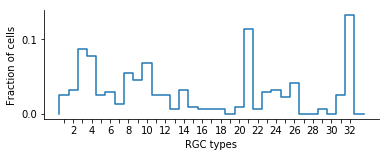

In [19]:

# Produce a histogram with all the experiments on it. With number of cells. 
Histo_groups = np.zeros(34)
for g in np.arange(34):
    try: Histo_groups[g+1] = Nc1[g]
    except: 1
 
fig = figure(figsize=(6,2))
ax = fig.add_subplot(1,1,1)
ax.step(np.arange(0,34)+0.5,Histo_groups/np.sum(Histo_groups))

ax.set_yticks([0,0.1])
ax.set_xticks(np.arange(32)+1)
ax.set_xticklabels(['',2,'',4,'',6,'',8,'',10,'',12,'',14,'',16,'',18,'',20,'',22,'',24,'',26,'',28,'',30,'',32])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Fraction of cells')
ax.set_xlabel('RGC types')


PDFsave= rootf + 'OUTPUT_NO_MEA/'
fsave = PDFsave + 'Histogram_types_MEA'
fig.savefig(fsave + '.pdf',format='pdf')

# Correlation matrix

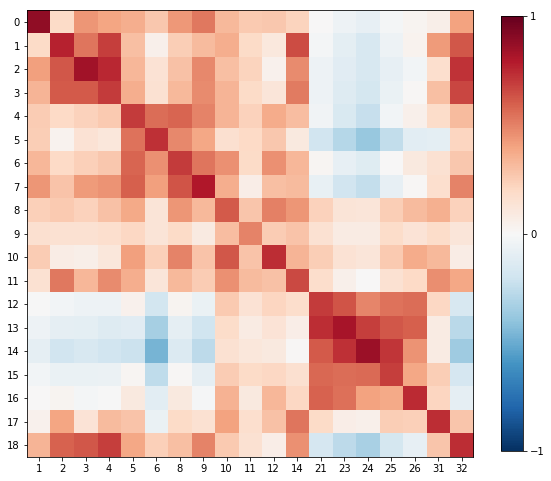

In [20]:
# it is computing for 28 groups
skip = [7,13,15,16,17,18,19,20,22,27,28,29,30]
skip = np.array(skip)-1

SKIP=True

t0 = 0
tf = 32

Glabels = []
Corr_mat_cg = np.zeros([len(G_LABELS.keys()),len(G_LABELS.keys())])
if SKIP: Corr_mat_cg = np.zeros([32-len(skip),32-len(skip)])
counti=0
countmat=0
for i in list(G_LABELS.keys()):#:np.arange(32):
    if i in skip:continue
    Glabels.append(i)
#     print(i)
    countj=0
    for j in list(G_LABELS.keys()):
        if j in skip: continue
        
        avg = 0
        count=0
        sel_groups = CLUSTERS[i]
        if i==31: sel_groups = [0,1,5]
        
        for g in sel_groups:
            for c in np.arange(len(Psthsc1[i][g]))[:]:   # loop cells in group
                avg+= np.corrcoef(Psthsc1[i][g][c],Totc1[j])[0,1]
    #             avg+= np.corrcoef(psth_z[c][t0*10:tf*10],toCalciumLinear(time[t0*10:tf*10],Ca_groups[list(groups)[countj]][t0*10:tf*10]))[0,1]
#                     toCalciumLinear(time,psth_z[i])

                count+=1
        Corr_mat_cg[counti,countj] = avg/count
        countj+=1
    counti+=1

fig=figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
neg= imshow(Corr_mat_cg,vmax=1,vmin=-1,cmap='RdBu_r')
# ax.set_xticks([])
# ax.set_yticks([])
# print(t0,tf)
cbar=fig.colorbar(neg,ticks=[-1,0.,1],   anchor=(0, 0.3), shrink=0.8)
if not SKIP:
    ax.set_xticks(np.arange(len((G_LABELS.keys()))))
ax.set_xticklabels(np.array(list(G_LABELS.keys()))+1)
if SKIP:
    ax.set_xticks(np.arange(32-len(skip)))
    ax.set_yticks(np.arange(32-len(skip)))
    
    ax.set_xticklabels(np.array(Glabels)+1)
PDFsave= rootf + 'OUTPUT_NO_MEA/'
fsave = PDFsave + 'Correlation_matrix_psth_vs_Psthmmeans'
if SKIP: fsave = PDFsave + 'Correlation_matrix_psth_vs_Psthmmeans-min5cells'
fig.savefig(fsave+'.pdf',format='pdf')



# SAVE data

In [22]:
#LABELS
NEW_LABELS  # IDENTICAL TO LABELS ALLOWS PLOTTING STATS FOR GROUPS WITH MORE THAN 1 ELEMENT (void for groups with 1 cell).
# this tells to which subgroup each cell belongs

#GROUPS = G_LABELS
# G_LABELS # UNIQUE LABELS LIST of cluster groups


CLUSTERS   # the clusters selected to make the final cut 

SubGroups32 # this renames all the subgroups in the group 31 into 0,1,5 (our 3 subgroups) and 6(discarded from classification)


SELECTED_CELLS[31]  # by each group, it lists the cells selected in each experiment
# data is [exp, cell_index in exp, cell_name_from_sorting]

#Subgroups32idx # Lists cells for group 32, subgroups are labeled 0,1,2 here (instead of 0,1,5)

# Bad cell is 66
BAD_CELLS # list of cells not used for analysis among conditions (bad or absent responses after)

[[65, 53],
 [2, 80, 6, 18, 21, 61, 72, 78, 82, 6],
 [10, 69, 9, 48, 54, 91, 93],
 [3, 5, 50, 59, 80, 87],
 [40, 58, 69],
 [52, 19, 46, 100],
 [],
 [62, 96],
 [92, 81, 52, 22, 4, 49, 140],
 [72, 68],
 [],
 [],
 [31],
 [32, 88, 93],
 [6, 35],
 [],
 [],
 [89],
 [],
 [],
 [36, 29, 52, 144],
 [5],
 [18, 20],
 [],
 [100],
 [],
 [],
 [],
 [48],
 [],
 [105, 19],
 [66]]

# PSTHs not normalized

In [23]:
help_txt= 'help:    Selected_cells gives the list of cells of group 32 [experiment,cell_index_in_exp,cell_sorting_number], numbering starts at 0,'\
             '         Subclustesr tells the subclusters into which all the cells in group 32 where divided (subgroup 3 belonged to Baden Type 8),'\
             '         LABELS tells to which subcluster each cell corresponds to,'\
             '         Subgroups32 tells the four final 4 groups from the Selected_cells (last group discarded),'\
             '         Subgroups32idx tells the experiment and index of the selected cells for the four groups 0,1,2,3,'\
             '         LABELS tells to which subcluster each cell corresponds to,'\
             '         Bad cell is one that did not have a good no response and discarded for further analysis,'\
             '         ',\
             '         For the following data, groups are labeled (groups are labeled 0,1,5 and 6 instead of 0,1,2,3)',\
             '         each variable has 17, 10 and 14 neurons, with data as [c1,no,wo] traces,'\
             '         ',\
             '         PSTHs_NN non normalized PSTHs',\
             '         PSTHs_Norm normalized PSTHs',\
             '         Ca_Norm normalized Ca transformed traces',\
             '         Ca_means and Ca_stds means and std of mean from previous traces'

In [24]:
# save data:
G=31

#-----------------------
PSTHs_NN = {}

for g in [0,1,5,6]:
    PSTHs_NN[g] = []
    
    for cell in np.arange(len(Psthsc1[G][g])):
    
        c1 = Psthsc1[G][g][cell]
        no = Psthsno[G][g][cell]
        wo = Psthswo[G][g][cell]
        data = [c1,no,wo]
    
        PSTHs_NN[g].append(data)
      
#---------------------
PSTHs_Norm = {}

for g in [0,1,5,6]:
    PSTHs_Norm[g] = []
    
    for cell in np.arange(len(Psthsc1[G][g])):
    
        c1 = Psthsc1[G][g][cell]/np.max(Psthsc1[G][g][cell])
        no = Psthsno[G][g][cell]/np.max(Psthsno[G][g][cell])
        wo = Psthswo[G][g][cell]/np.max(Psthswo[G][g][cell])
        data = [c1,no,wo]
    
        PSTHs_Norm[g].append(data)
                                  
#-----------------------
Ca_NN = {}

for g in [0,1,5,6]:
    Ca_NN[g] = []
    
    for cell in np.arange(len(Cac1[G][g])):
    
        c1 = Cac1[G][g][cell]
        no = Cano[G][g][cell]
        wo = Cawo[G][g][cell]
        data = [c1,no,wo]
    
        Ca_NN[g].append(data)
      
#---------------------
Ca_Means = {}
Ca_stds = {}

for g in [0,1,5,6]:
    
    c1 = CaMc1[G][g]
    no = CaMno[G][g]
    wo = CaMwo[G][g]                               
                                        
    Ca_Means = [c1,no,wo]
                                        
    c1 = CaSc1[G][g]
    no = CaSno[G][g]
    wo = CaSwo[G][g]                               
                                        
    Ca_stds = [c1,no,wo]

#---------------------

DATA = {}

DATA.update({'PSTHs_NN':PSTHs_NN})
DATA.update({'PSTHs_norm':PSTHs_Norm})
DATA.update({'Ca_Norm':Ca_NN})
DATA.update({'Ca_means':Ca_Means})
DATA.update({'Ca_stds':Ca_stds})


DATA.update({'Selected_cells':SELECTED_CELLS[31]})                                        
DATA.update({'CLUSTERS':CLUSTERS[31]})                                        
DATA.update({'LABELS':LABELS[31]})  
DATA.update({'Subgroups32idx':Subgroups32idx})    
DATA.update({'Subgroups32':SubGroups32})   
DATA.update({'Bad_cell':66})    
   
DATA.update({'help':help_txt})    

save_obj(DATA,'./DATA_for_review')

# PSTH plots

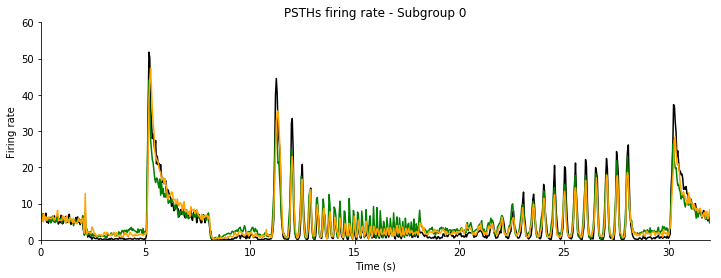

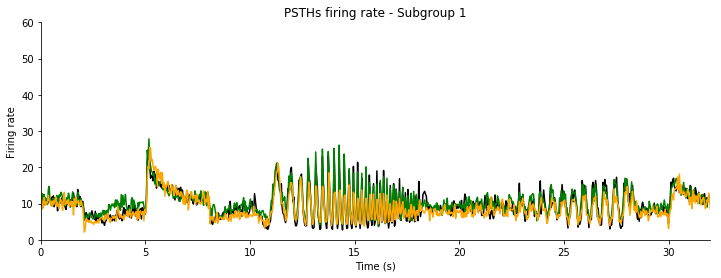

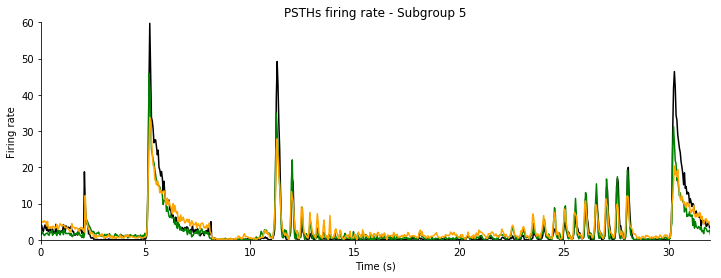

In [42]:
psthnn = DATA['PSTHs_NN']
time = np.linspace(0,32,800)
for g in [0,1,5]:
# g=5
    c1 = 0
    no = 0
    wo = 0

    for cell in psthnn[g]:
        c1+=cell[0]
        no+=cell[1]
        wo+=cell[2]
    c1=c1/len(psthnn[g])    
    no=no/len(psthnn[g])    
    wo=wo/len(psthnn[g])  


    fig = figure(figsize=(12,4))
    ax=fig.add_subplot(1,1,1)
    ax.plot(time,c1,'k')
    ax.plot(time,no,'g')
    ax.plot(time,wo,'orange')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title('PSTHs firing rate - Subgroup '+str(g))
    ax.set_ylabel('Firing rate')
    ax.set_xlabel('Time (s)')
    
    ax.set_ylim(0,60)
    ax.set_xlim(0,32)
    ax.set_xlim(0,32)
    
    fsave = 'OUTPUT_NO_MEA/' + 'Group'+str(G)+' subgroup '+ str(g) +'_PSTH_not_normalized_'+str(Ncells[G][g]) +'cells_3curves'
    fig.savefig(fsave + '.pdf',format='pdf')


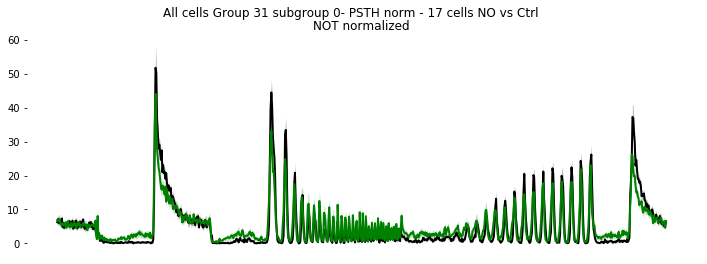

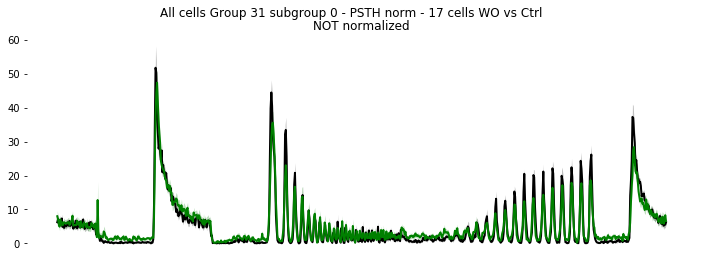

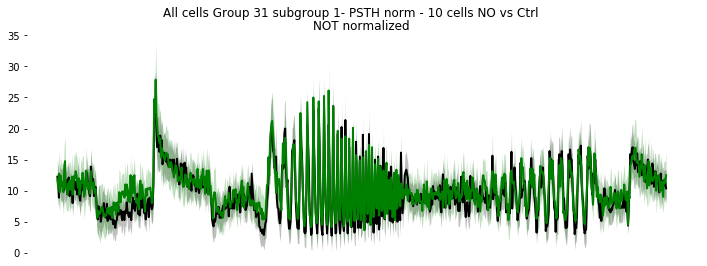

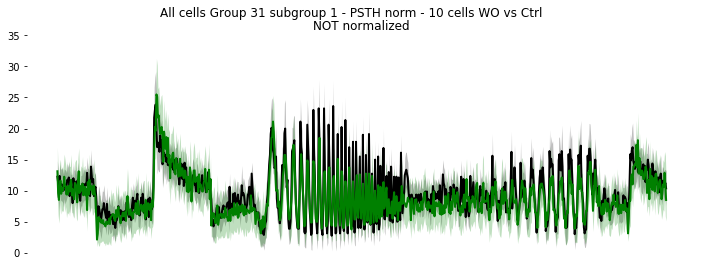

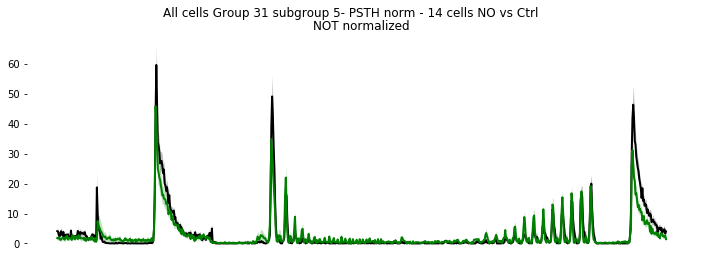

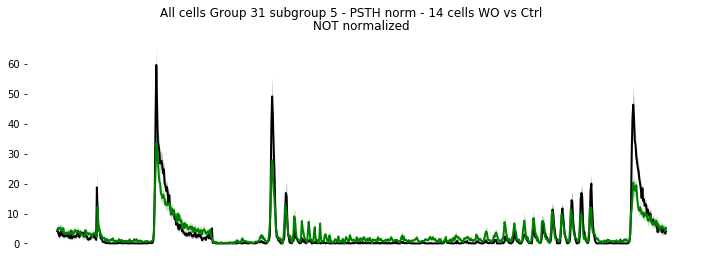

In [44]:
G=31

# for g in CLUSTERS[G]:

for g in [0,1,5]:
    #---------------------

    c1 = []
    no = []
    wo = []
    
    for cell in np.arange(len(Psthsc1[G][g])):
        p={}
        p[1] = Psthsno[G][g][cell]#/np.max(Psthsc1[G][g][cell])
        p[2] = Psthswo[G][g][cell]#/np.max(Psthsc1[G][g][cell])
        p[0] = Psthsc1[G][g][cell]#/np.max(Psthsc1[G][g][cell])
        c1.append(p[0])
        no.append(p[1])
        wo.append(p[2])
        #------

    mC1 = np.mean(c1,axis=0)
    mC1 = mC1#/np.max(mC1)
    mNO = np.mean(no,axis=0)#/np.max(mC1)
    mWO = np.mean(wo,axis=0)#/np.max(mC1)
    sC1 = np.std(c1,axis=0)/sqrt(Ncells[G][g])#/np.max(mC1)
    sNO = np.std(no,axis=0)/sqrt(Ncells[G][g])#/np.max(mC1)
    sWO = np.std(wo,axis=0)/sqrt(Ncells[G][g])#/np.max(mC1)
    #---------------------
    
    fig=figure(figsize=(12,4))
    fig.suptitle('All cells Group '+str(G)+' subgroup '+str(g)  +'- PSTH norm - '+str(Ncells[G][g])+' cells NO vs Ctrl')

    ax = fig.add_subplot(1,1,1)
    ax.set_title('NOT normalized')

    ax.fill_between(time, mC1-sC1, mC1+sC1, color='k', alpha=0.25,lw=0)
    ax.plot(time,mC1,'k',label='c1',lw=2)
    # ax.plot(baden_time,Baden_types[31],'r',label='Baden')

    ax.fill_between(time, mNO-sNO, mNO+sNO, color='g', alpha=0.25,lw=0)
    ax.plot(time,mNO,'g',label='no',lw=2)

    if g==1: ax.set_ylim(0,35)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylabel('Normalized PSTH transform (to ctrl1)')
    ax.set_xlabel('Time (s)')
#     ax.legend()
    ##############
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
#     ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ##############


    fsave = PDFsave + 'Group'+str(G)+' subgroup '+ str(g) +'_PSTH_All_NN_'+str(Ncells[G][g])+'cells_c1-no' 
    fig.savefig(fsave + '.pdf',format='pdf')
#     close(fig)
    

    #===============
#     Control figure
#     all groups together

    fig=figure(figsize=(12,4))
    fig.suptitle('All cells Group '+str(G)+' subgroup '+str(g) +' - PSTH norm - '+str(Ncells[G][g])+' cells WO vs Ctrl')

    ax= fig.add_subplot(1,1,1)
    ax.set_title('NOT normalized')

    ax.fill_between(time, mC1-sC1, mC1+sC1, color='k', alpha=0.25,lw=0)
    ax.plot(time,mC1,'k',label='c1',lw=2)
    # ax.plot(baden_time,Baden_types[31],'r',label='Baden')

    ax.fill_between(time, mWO-sWO, mWO+sWO, color='g', alpha=0.25,lw=0)
    ax.plot(time,mWO,'g',label='wo',lw=2)

#     ax.set_ylim(-0.2,1.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ##########
    

    ax.set_ylabel('Normalized Ca transform (to ctrl1)')
    ax.set_xlabel('Time (s)')
    if g==1: ax.set_ylim(0,35)
#     ax.legend()
    ##############
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
#     ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ##############
    

    fsave = 'OUTPUT_NO_MEA/' + 'Group'+str(G)+' subgroup '+ str(g) +'_PSTH_All_NN_'+str(Ncells[G][g])+'cells_c1-wo' 
    fig.savefig(fsave + '.pdf',format='pdf')
    
#     close(fig)


# Calcium data

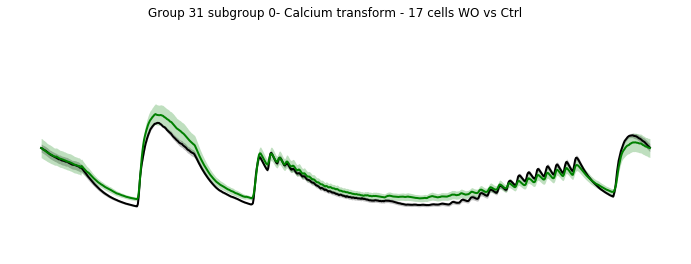

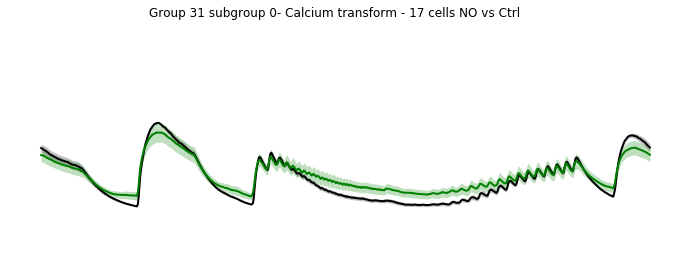

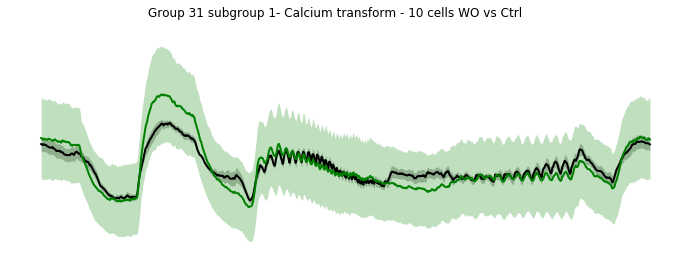

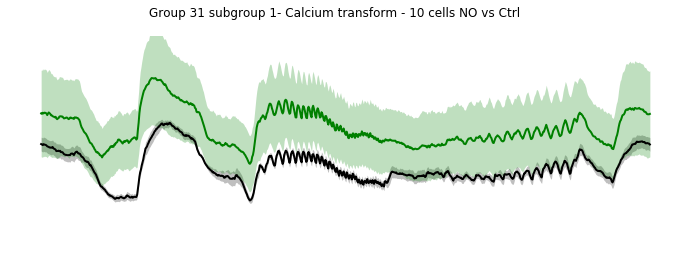

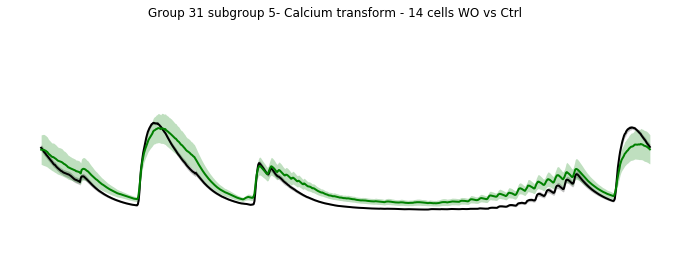

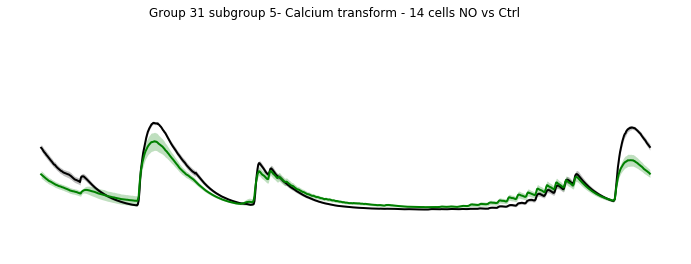

In [48]:
G=31

# Subgroups
for g in [0,1,5]:
    
    fig=figure(figsize=(12,4))
    fig.suptitle('Group ' + str(G)+ ' subgroup '+ str(g) + '- Calcium transform - '+str(Ncells[G][g]) +' cells WO vs Ctrl')

    ax= fig.add_subplot(1,1,1)

    ax.fill_between(time, CaMc1[G][g]-CaSc1[G][g], CaMc1[G][g]+CaSc1[G][g], color='k', alpha=0.25,lw=0)
    ax.plot(time,CaMc1[G][g],'k',label='c1',lw=2)
    # ax.plot(baden_time,Baden_types[31],'r',label='Baden')

    ax.fill_between(time, CaMwo[G][g]-CaSwo[G][g], CaMwo[G][g]+CaSwo[G][g], color='g', alpha=0.25,lw=0)
    ax.plot(time,CaMwo[G][g],'g',label='wo',lw=2)

    ax.set_ylim(-0.5,2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax.set_ylabel('Normalized Ca transform (to ctrl1)')
    ax.set_xlabel('Time (s)')

#     ax.legend()
    ##############
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ##############
    
    fsave = PDFsave + 'Group_' +str(G) + 'subgroup_'+ str(g) +'_Ca_mean_'+str(Ncells[G][g]) +' cells_c1-wo' 
    fig.savefig(fsave + '.pdf',format='pdf')
    
    #------------------------------------------
    fig=figure(figsize=(12,4))
    fig.suptitle('Group ' + str(G)+ ' subgroup '+ str(g) + '- Calcium transform - '+str(Ncells[G][g]) +' cells NO vs Ctrl')

    ax= fig.add_subplot(1,1,1)

    ax.fill_between(time, CaMc1[G][g]-CaSc1[G][g], CaMc1[G][g]+CaSc1[G][g], color='k', alpha=0.25,lw=0)
    ax.plot(time,CaMc1[G][g],'k',label='c1',lw=2)
    # ax.plot(baden_time,Baden_types[31],'r',label='Baden')

    ax.fill_between(time, CaMno[G][g]-CaSno[G][g], CaMno[G][g]+CaSno[G][g], color='g', alpha=0.25,lw=0)
    ax.plot(time,CaMno[G][g],'g',label='no',lw=2)

    ax.set_ylim(-0.5,2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax.set_ylabel('Normalized Ca transform (to ctrl1)')
    ax.set_xlabel('Time (s)')

#     ax.legend()
    ##############
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ##############
    
    fsave = 'OUTPUT_NO_MEA/' + 'Group_' +str(G) + 'subgroup '+ str(g) +'_Ca_mean_'+str(Ncells[G][g]) +' cells_c1-no' 
    fig.savefig(fsave + '.pdf',format='pdf')      

In [ ]:
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################